<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 1 - Food Classification Model (Individual)</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

# Imports & Setup

In [1]:
# Import the Required Packages
import os
import dask as d
import mlflow
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import dask.bag as db
import tensorflow as tf
from git import Repo
from uuid import uuid4
from tempfile import mkdtemp, NamedTemporaryFile
from shutil import rmtree
from random import randint
from io import BytesIO
from minio import Minio
from math import floor
from typing import Tuple, Optional
from mlflow.entities import ViewType, RunStatus
from mlflow.tracking import MlflowClient
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from multiprocessing.pool import ThreadPool
from multiprocessing import cpu_count
from dask.distributed import Client

`TF_FORCE_GPU_ALLOW_GROWTH` -  Force Tensorflow to allocate GPU memory dynamically
instead of of all at once as a workaround for this
[cuDNN failed to initialize issue](https://github.com/tensorflow/tensorflow/issues/24828).

In [2]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


Configure access to `minio` -  S3 store which stores the dataset.

In [3]:
minio = Minio(os.environ["MINIO_HOST"],
              access_key=os.environ["MINIO_ACCESS_KEY"],
              secret_key=os.environ["MINIO_SECRET_KEY"],
              secure=False)

Configure access to `dask` for parallelised computation.

In [4]:
dask_cli = Client(
    # make sure we dont hit OOM errors
    memory_limit="2GB"
)
dask_cli

Client Scheduler: tcp://127.0.0.1:34727 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 8.00 GB


Configure access to MLFlow by setting the following environment variables:
- `MLFLOW_TRACKING_URI` - URL to the MLFlow Tracking server.
- `MLFLOW_S3_ENDPOINT_URL` - URL to the MLFlow S3 Backend Store.


## Step 0: Exploratory Data Analysis
Pull paths of images in the dataset from `minio`

In [5]:
DATA_BUCKET = "datasets"
DATASET = "food-101"
img_files = list(
    minio.list_objects_v2(bucket_name=DATA_BUCKET,
                          prefix=DATASET,
                          recursive=True)
)
img_paths = [f.object_name for f in img_files]
img_paths[0]

'food-101/test/beef_carpaccio/103294.jpg'

Extract dataset image metadata into a dataframe:
-  data `subset` it belong to (ie train/test/validation).
- `label` from the path from image path
-  image size - width and height.

In [6]:
%%time
# extract subset and label from image path
img_parts = [ f.split("/") + [f] for f in img_paths ]
# retrieve size of dataset images
def read_img(f):
    minio = Minio(os.environ["MINIO_HOST"],
              access_key=os.environ["MINIO_ACCESS_KEY"],
              secret_key=os.environ["MINIO_SECRET_KEY"],
              secure=False)
    resp = minio.get_object(DATA_BUCKET, f)
    img_bytes = BytesIO(resp.read())
    resp.close()
    resp.release_conn()
    return Image.open(img_bytes)
imgs = db.from_sequence(img_paths, npartitions=200).map(read_img)
img_sizes = imgs.map((lambda img: img.size)).compute()

CPU times: user 1.14 s, sys: 107 ms, total: 1.25 s
Wall time: 8.34 s


In [7]:
# construct dataframe with dataset image metadata
df = pd.DataFrame(img_parts, columns=[
    "dataset",
    "subset",
    "label",
    "fname",
    "path",
])
df["size"] = img_sizes
df = df.drop(columns=["dataset", "fname"])
# convert categorical column to category dtype
for cat_col in [ "label", "subset" ]:
    df[cat_col] = df[cat_col].astype("category")
eda_df = df[["subset","label","size"]]
df.head()

,subset,label,path,size
0,test,beef_carpaccio,food-101/test/beef_carpaccio/103294.jpg,"(382, 512)"
1,test,beef_carpaccio,food-101/test/beef_carpaccio/1097159.jpg,"(289, 512)"
2,test,beef_carpaccio,food-101/test/beef_carpaccio/1130229.jpg,"(512, 512)"
3,test,beef_carpaccio,food-101/test/beef_carpaccio/1142668.jpg,"(512, 512)"
4,test,beef_carpaccio,food-101/test/beef_carpaccio/120791.jpg,"(512, 384)"


Compute descriptive statisitics on dataset metadata:

In [8]:
eda_df.describe()

,subset,label,size
count,10000,10000,10000
unique,3,10,221
top,train,strawberry_shortcake,"(512, 512)"
freq,7500,1000,6157


Visualize distribution of dataset by subset:

train         7500
validation    2000
test           500
Name: subset, dtype: int64


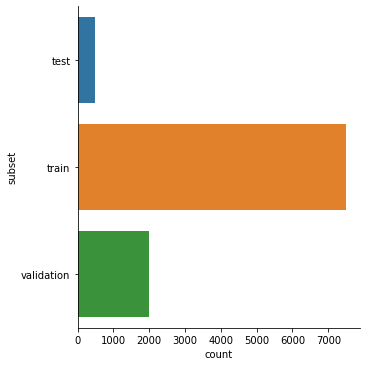

In [9]:
print(eda_df["subset"].value_counts())
sns.catplot(y="subset", kind="count", data=eda_df)

Visualize distribution of dataset by food category (`label`):

strawberry_shortcake    1000
fried_rice              1000
french_toast            1000
fish_and_chips          1000
dumplings               1000
churros                 1000
chocolate_cake          1000
cheese_plate            1000
bibimbap                1000
beef_carpaccio          1000
Name: label, dtype: int64
10


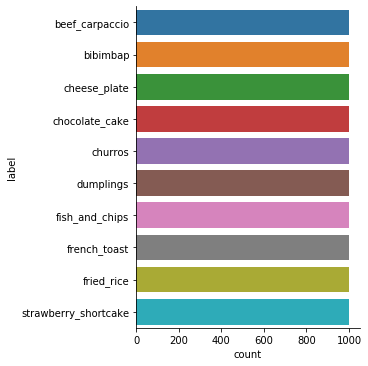

In [10]:
print(eda_df["label"].value_counts())
print(eda_df["label"].nunique())
sns.catplot(y="label", kind="count", data=eda_df)

> Since there is no data imbalance between classes, no resampling needs to be done.

Inspecting the distribution of image sizes:

In [11]:
print(eda_df["size"].value_counts())
print(f"Dataset contains {eda_df['size'].nunique()} image sizes.")

(512, 512)    6157
(512, 384)    1506
(384, 512)     613
(382, 512)     239
(512, 382)     227
              ... 
(389, 512)       1
(512, 355)       1
(415, 512)       1
(512, 230)       1
(512, 375)       1
Name: size, Length: 221, dtype: int64
Dataset contains 221 image sizes.


> Since there are multiple image sizes, the images would have to resized to conform to a standard size.

In [12]:
print("Top 5 Smallest image sizes:")
sorted(eda_df["size"].unique() , key=(lambda size: size[0] * size[1]))[:5]

Top 5 Smallest image sizes:


[(512, 222), (512, 226), (512, 230), (512, 231), (512, 236)]

Compute descriptive statstics on the dataset images:
- Workaround the multiple image sizes by computing the statistics for each individual image.
- Aggregate the statistics for each sample to derive dataset statistic.
- Use `dask` to do statistics computation as dataset does not fit into memory
- Compute statistics by channel to get more accurate estimates.

In [13]:
%%time
img_arrs = imgs.map((lambda img: np.asarray(img)))

# total number of pixels per channel in the dataset
n_channel_pixels = (
    img_arrs
    # multiply height * width dims
    .map((lambda arr: arr.shape[0] * arr.shape[1]))
    .sum()
)

min_rgb = (
    img_arrs
    # compute min by channel dim
    .map((lambda arr: arr.min(axis=(0, 1))))
    .fold((lambda min_a, min_b: np.minimum(min_a, min_b)))
)

max_rgb = (
    img_arrs
    # compute max by channel dim
    .map((lambda arr: arr.max(axis=(0, 1))))
    .fold((lambda max_a, max_b: np.maximum(max_a, max_b)))
)

mean_rgb = (
    img_arrs
    # compute mean by channel dim
    .map((lambda arr: arr.mean(axis=(0, 1))))
    .fold((lambda max_a, max_b: np.mean([max_a, max_b], axis=0)))
)

n_channel_pixels, min_rgb, max_rgb, mean_rgb = d.compute(
    n_channel_pixels,  min_rgb,  max_rgb, mean_rgb
)

CPU times: user 4.33 s, sys: 321 ms, total: 4.65 s
Wall time: 37.5 s


In [14]:
%%time
std_rgb = (
    img_arrs
    # compute by channel dim:
    # sum((x - mean)^ 2)
    # ----------------------
    # n_channel_pixels - 1
    .map((lambda arr: np.sum(((arr - mean_rgb) ** 2), axis=(0, 1))))
    .sum()
    .compute() / (n_channel_pixels - 1)
) ** 0.5

CPU times: user 2.2 s, sys: 197 ms, total: 2.39 s
Wall time: 26.9 s


In [15]:
print("min RGB:", min_rgb)
print("max RGB:", max_rgb)
print("mean RGB:", mean_rgb)
print("standard deviation RGB:", std_rgb)

min RGB: [0 0 0]
max RGB: [255 255 255]
mean RGB: [133.36350383 109.78761907  94.96847991]
standard deviation RGB: [70.36123406 71.24328341 71.43638741]


## Step 1: Load Dataset and Prepare Data

### Image Generator

Define a custom data generator `MinioImgGen` prepares a batch of data by:
- Pulls image data from the dataset from `minio` in the `DATA_BUCKET`
- Perform image augumentation using `albumentations`
- One hot encoding the labels/classes into one hot vectors
- Preprocess images 

In [16]:
class MinioImgGen(Sequence):
    def __init__(self,  
                 minio_client: Minio, 
                 bucket: str, 
                 labels_df: pd.DataFrame, 
                 n_classes: int,
                 img_size: Tuple[int, int],
                 mean_rgb: np.ndarray,
                 std_rgb: np.ndarray,
                 batch_size=1024,
                 use_preprocessing=True,
                 use_augumentation=True):
        """Create a new data generator that feeds model-ready data from minio 
        
        Obtains data from minio, optionally performs image augumentation and
        performs preprocessing to clean the data for model use.
        
        Args:
            minio_client: minio client that can be used to retrieve the dataset.
            bucket: name of the bucket that contains the dataset.
            labels_df: 
                Dataframe containing the subset (ie train/test), label and its path
                in the data bucket where the image can be retrieved.
            n_classes:
                Max number of possible classes/labels the generated images belong to.
            img_size:
                Tuple of width height to resize the images to.
            mean_rgb:
                Numpy array of shape (3,) containing the mean computed
                by each Red Green Blue channel used for preprocessing data.
            std_rgb:
                Numpy array of shape (3,) containing the standard deviation computed
                by each Red Green Blue channel used for preprocessing data.
            batch_size: Size of the image batch returned by this generator
            use_augmentation: Whether to use use image augumentation.
            use_preprocessing: 
                Whether to do image preprocessing to clean data for model use.
                Pass a Function to do custom image preprocessing.
                True for standard scaling image preprocessing using given std_rgb, mean_rgb.
                False for no image preprocessing.
        """
        self.minio, self.bucket, self.labels_df = minio_client, bucket, labels_df
        self.n_classes, self.img_size = n_classes, img_size
        self.batch_size, self.use_preprocessing = batch_size, use_preprocessing
        self.mean_rgb, self.std_rgb = mean_rgb, std_rgb
        if use_augumentation:
            self.augmentation = self.build_aug()
        else:
            self.augmentation = self.build_non_aug()
        # create thread pool used to speed up image generator by parallelising
        self.threads = ThreadPool(processes=cpu_count())
        self.on_epoch_end()
        
    def on_epoch_end(self):
        # shuffle the order which the data is fed to the model every epoh
        self.epoch_df = self.labels_df.sample(frac=1) 
    
    def __len__(self):
        # return the number of batches per epoch
        return floor(len(self.epoch_df) / self.batch_size)
    
    def build_aug(self):
        # build image augumentation transform
        return A.Compose([
            A.RandomResizedCrop(*self.img_size),
            A.HorizontalFlip(),
            A.Rotate(limit=45, p=0.6),
            A.RandomBrightnessContrast(),
            A.GaussNoise(p=0.3),
            # distortions
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1),
                A.IAASharpen(),
                A.IAAEmboss(),
                A.CLAHE(clip_limit=2),
            ]),
            # Blurs
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.Blur(p=0.1),
                A.MedianBlur(blur_limit=3, p=0.2),
                A.ImageCompression(p=0.3, quality_lower=40, quality_upper=85),
            ]),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=8, p=0.5),
                A.ToGray(p=0.01),
            ])
        ])
    
    def build_non_aug(self):
        # build non augumentation transform
        return A.Compose([
            A.CenterCrop(*self.img_size)
        ])

    # according the the profiler, this operation takes the longest per call
    # optimize [erformance using numba JIT.
    @staticmethod
    @numba.jit(nopython=True)
    def preprocess(img_arrs: np.ndarray,
                   mean_rgb: np.ndarray,
                   std_rgb: np.ndarray):
        # perform standardisation to preprocess data
        return (img_arrs - mean_rgb) / std_rgb

    def __getitem__(self, batch_idx: int):
        # generate a batch_idx of data batch of data
        batch_df = self.epoch_df[batch_idx * self.batch_size: 
                                 (batch_idx + 1) * self.batch_size]

        # TODO: experiment with dask to see if a speedup can be observed.
        # pull and read the image samples from minio
        def read_bytes(path):
            resp = self.minio.get_object(self.bucket, path)
            b = BytesIO(resp.read())
            resp.close()
            resp.release_conn()
            return b
        img_bytes = self.threads.map(read_bytes, batch_df["path"])

        # read images
        imgs = [Image.open(b) for b in  img_bytes]
        img_arrs = [np.asarray(i) for i in imgs]

        # apply image transforms (ie augumentations)
        img_arrs = np.stack(self.threads.map(
            (lambda img_arr: self.augmentation(image=img_arr)["image"]),
            img_arrs,
        ))

        # apply preprocess to clean data for model use
        if self.use_preprocessing == True:
            img_arrs = MinioImgGen.preprocess(img_arrs, self.mean_rgb, self.std_rgb)
        elif callable(self.use_preprocessing):
            img_arrs = self.use_preprocessing(img_arrs)

        # one hot encode labels
        labels = to_categorical(batch_df["label"].cat.codes,
                                num_classes=self.n_classes)
        return img_arrs, labels

Check that the `MinioImgGen` can generate images and is relatively performant:
- Since this is called during training for every batch, performance overhead
  from `MinioImgGen` can significantly increase training time.

In [17]:
trailgen = MinioImgGen(
    minio_client=minio,
    bucket=DATA_BUCKET,
    labels_df=df,
    img_size=(222, 222),
    n_classes=df["label"].nunique(),
    mean_rgb=mean_rgb,
    std_rgb=std_rgb,
    batch_size=1024,
    use_preprocessing=True,
    use_augumentation=True,
)
%timeit trailgen.__getitem__(1)

4.33 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Visualise images produced by `MinioImgGen`

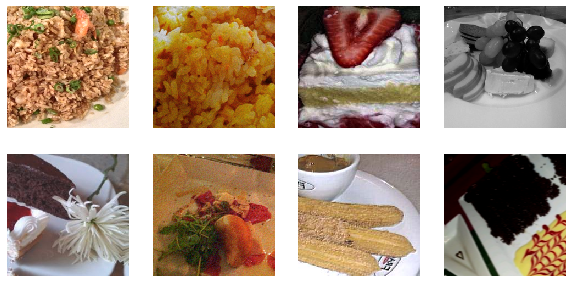

In [18]:
# disable preprocessing to make images humanly recongizable
trailgen.use_preprocessing = False
imgs, y = trailgen.__getitem__(1)
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = randint(0, len(imgs))
        ax.set_axis_off()
        ax.imshow(imgs[idx])

### Dataset Subsets
Configure data generators for train/test and validation subsets

In [19]:
def get_datagens(img_size: Tuple[int, int],
                 batch_size: int,
                 df: pd.DataFrame,
                 minio=minio,
                 bucket=DATA_BUCKET,
                 use_preprocessing=True,
                 mean_rgb=mean_rgb,
                 std_rgb=std_rgb):
    """Get train/validation data generators

    Args:
        img_size: Width, height tuple specifying the dimensions of the images produced.
        batch_size: Size of the batches produced
        labels_df: Dataframe containing data subset, path, and label.
        minio: minio client that can be used to retrieve the dataset.
        bucket: name of the bucket that contains the dataset.
        mean_rgb:
            Numpy array of shape (3,) containing the mean computed
            by each Red Green Blue channel used for preprocessing data.
        std_rgb:
            Numpy array of shape (3,) containing the standard deviation computed
            by each Red Green Blue channel.
        use_preprocessing: 
            Whether to do image preprocessing to clean data for model use.
            Pass a Function to do custom image preprocessing.
            True for standard scaling image preprocessing using given std_rgb, mean_rgb.
            False for no image preprocessing.
    Returns:
        Train, Validation, Test dataDataset Subsets generators
    """
    common_params = {
        "minio_client": minio,
        "bucket": DATA_BUCKET,
        "img_size": img_size,
        "batch_size": batch_size,
        "mean_rgb": mean_rgb,
        "std_rgb": std_rgb,
        "use_preprocessing": use_preprocessing,
        "n_classes": df["label"].nunique(),
    }

    train_gen = MinioImgGen(
        **common_params,
        labels_df=df[df["subset"] == "train"],
        use_augumentation=True,
    )
    valid_gen = MinioImgGen(
        **common_params,
        labels_df=df[df["subset"] == "validation"],
        use_augumentation=False,
    )
    test_gen = MinioImgGen(
        **common_params,
        labels_df=df[df["subset"] == "test"],
        use_augumentation=False,
    )

    return train_gen, valid_gen, test_gen

## Step 2:  Develop the Image Classification Models

### Model #1
Build the _From Scratch_ Model composed of:
- Convolution Blocks composed of convolution, batch normzalization and any regularization.
- Resnet Blocks composed of multiple convolution blocks and residual connections.
- Dense Classifier block used to generate final predictions.

Define a convolution block as a building block for our CNN model:

In [20]:
def conv_block(in_op,
               n_filters=32,
               filter_size=(3, 3),
               l2_reg=None,
               use_batch_norm=True,
               dropout_prob=0.0,
               relu_leak=3e-2,
              ):
    """Append convolution block to the given input tensor in_op"""
    x = in_op
    x = Conv2D(
        filters=n_filters, 
        kernel_size=filter_size,
        padding="same",
        kernel_regularizer=None if l2_reg is None else l2(l=l2_reg),
    )(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    if dropout_prob > 0.0:
        x = Dropout(dropout_prob)(x)
    x = LeakyReLU(relu_leak)(x)
    return x

Define a Renset block that uses the convolution block with Resnet style skip connnects for faster training

In [21]:
def resnet_block(in_op,
                 n_conv_blocks=3,
                 **conv_params):
    """Append a resnet style conolution block to the given in_op"""
    x = in_op
    for l in range(n_conv_blocks):
        x = conv_block(x, **conv_params)
    # since the channels dimensions may be different x and in_op,
    # we apply a 1 by 1 conv on in_op ensure the channel dim matches up
    l2_reg = conv_params["l2_reg"]
    in_op = Conv2D(
        filters=conv_params["n_filters"],
        kernel_size=(1, 1),
        kernel_regularizer=None if l2_reg is None else l2(l=l2_reg),
        padding="same",
        use_bias=False
    )(in_op)
    x = Add()([x, in_op])
    return x

Define a Fully connnected classifier block that produces multiclass softmax probablities:
- one hidden layer followed by an output layer configured to output probablities for each class

In [22]:
def dense_classifier(in_op,
                     n_dense_units=128,
                     n_classes=10,
                     regularizer=None,
                     use_batch_norm=True,
                     dropout_prob=0.0,
                     l2_reg=None,
                     relu_leak=3e-2):
    """Append a dense classfier block to the given in_op"""
    x = in_op
    x = Dropout(dropout_prob)(x)
    x = Dense(
        units=n_dense_units,
        kernel_regularizer=None if l2_reg is None else l2(l=l2_reg),
    )(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_prob)(x)
    x = LeakyReLU(relu_leak)(x)
    # classifier output layer
    x = Dense(
        units=n_classes,
        activation="softmax",
        kernel_regularizer=None if l2_reg is None else l2(l=l2_reg),
    )(x)
    return x

Putting the building blocks together to build a model:
- Start with a convolution block and pool.
- Perform convolution with resnet blocks with increasing no. of filters, and pooling to reduce feature map spatial dims.
- Global Average pool to remove spatial dims entirely, leaving only channels.
- Make multi-class predictions using dense classifer block.


In [23]:
def build_model(input_shape=(256, 256, 3),
                in_conv_filter_size=(7, 7),
                conv_filter_size=(3, 3),
                n_classes=10,
                n_conv_filters=[
                    32,
                    64,
                    128,
                ],
                n_conv_blocks=3,
                n_resnet_blocks=1,
                n_dense_units=128,
                **block_params):
    in_op = Input(shape=input_shape)
    x = in_op
    # use larger filter size on input to gain more global infomation
    x = conv_block(
        in_op=x,
        n_filters=n_conv_filters[0],
        filter_size=in_conv_filter_size,
        **block_params
    )
    x = MaxPool2D(pool_size=(2, 2))(x)

    # add resnet blocks based on n_filters filter spec
    for i_filter, n_filter in enumerate(n_conv_filters):
        for i_block in range(n_resnet_blocks):
            x = resnet_block(
                in_op=x,
                n_conv_blocks=n_conv_blocks,
                n_filters=n_filter,
                filter_size=conv_filter_size,
                **block_params,
            )
        # add max pooling to all layers except last layer
        if i_filter < (len(n_conv_filters) - 1):
            x = MaxPool2D(pool_size=(2, 2))(x)

    # apply global avg pooling to remove spatial dimensions
    x = GlobalAveragePooling2D()(x)
    
    # dense layer to produce classifications
    x = dense_classifier(
        in_op=x,
        n_dense_units=n_dense_units,
        n_classes=n_classes,
        **block_params
    )
    
    return Model(
        inputs=in_op,
        outputs=x,
    )

Define callbacks to add custom functionality during training:
- `TensorBoard` callback records training progress for later viewing with tensorboard.
- `ReduceLROnPlateau` callback reduces learning rate when the model is 
    stuck (ie `val_loss` does not move for `patience` epochs).
- `mlflow_log` custom callback logs params, metrics and trained model  to MLFlow.

In [24]:
def compile_callbacks(reduce_lr_stuck, reduce_lr_patience, reduce_lr_factor):
    # compile callbacks
    callbacks = []
    # callback to log tensorboard
    log_dir = mkdtemp()
    tensorboard = TensorBoard(log_dir=log_dir)
    callbacks.append(tensorboard)

    # callback to reduce lr on stuck on plateau
    mlflow.log_param("reduce_lr_stuck", reduce_lr_stuck)
    if reduce_lr_stuck:
        callbacks.append(
            ReduceLROnPlateau(
                factor=reduce_lr_factor,
                patience=reduce_lr_patience, 
                monitor="loss",
            )
        )
        mlflow.log_params({
            "reduce_lr_factor": reduce_lr_factor,
            "reduce_lr_patience": reduce_lr_patience,
        })
    # callback to log to tensorboard during model training
    def on_epoch_end(n_epoch, logs):
        mlflow.log_metrics(logs, step=n_epoch)
    def on_train_end(logs=None):
        # due to this issue https://github.com/tensorflow/tensorflow/issues/38498
        # logs is always none.
        mlflow.log_artifacts(log_dir, "tensorboard_logs")
        rmtree(log_dir, ignore_errors=True)
    mlflow_log = LambdaCallback(
        on_epoch_end=on_epoch_end,
        on_train_end=on_train_end,
    )
    callbacks.append(mlflow_log)
    return callbacks

Putting it all together with `train_eval_model()`:
- compiles, trains, evaluates model from `build_model()`
- records model run to mlflow tracking.

In [25]:
def train_eval_model(labels_df: pd.DataFrame,
                     git_repo: Repo,
                     build_model_fn=build_model,
                     use_preprocessing=True,
                     epochs=30,
                     lr=1e-3,
                     optimizer="adam",
                     sgd_momentum=0.9,
                     loss="categorical_crossentropy",
                     metrics=[
                         "accuracy",
                     ],
                     img_size=(256, 256),
                     reduce_lr_stuck=False,
                     reduce_lr_patience=5,
                     reduce_lr_factor=0.1,
                     batch_size=32,
                     tags={
                         "project": "dl-assign-1",
                         "kind": "from-scratch",
                     },
                     run_name=None,
                     experiment_name="food_101_from_scratch",
                     **build_params):

    # setup mlflow experiment and run for logging run to mlflow tracking
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name) as run:
        # tags for the experiment
        # pull metadata form git repository and tag
        tags["git-ref"] = git_repo.head.commit.hexsha
        tags["version"] = git_repo.git.describe("--always")
        mlflow.set_tags(tags)
        
        # obtain data generators
        train_gen, valid_gen, test_gen = get_datagens(
            df=labels_df,
            img_size=img_size,
            batch_size=batch_size,
            use_preprocessing=use_preprocessing,
        )
        mlflow.log_param("img_size", img_size)
        mlflow.log_param("batch_size", batch_size)
        
        # build model
        model = build_model_fn(
            input_shape=img_size + (3,),
            n_classes=labels_df["label"].nunique(),
            **build_params
        )
        mlflow.log_params(build_params)
        # write summary to mlflow
        temp_dir = mkdtemp()
        summary_fpath = os.path.join(temp_dir, "summary.txt")
        with open(summary_fpath, "w") as f:
            model.summary(print_fn=(lambda line: f.write(f"{line}\n")))
        mlflow.log_artifact(summary_fpath)
        rmtree(temp_dir)

        # compile model
        optimizers = {
            "adam": Adam(learning_rate=lr),
            "rmsprop": RMSprop(learning_rate=lr),
            "sgd": SGD(learning_rate=lr, momentum=sgd_momentum),
        }
        model.compile(
            optimizer=optimizers[optimizer],
            loss=loss,
            metrics=metrics,
        )
        mlflow.log_params({
            "optimizer": optimizer,
            "loss": loss,
            "metrics": metrics,
            "learning_rate": lr,
        })
        if optimizer == "sgd":
            mlflow.log_param("sgd_momentum", sgd_momentum)

        # train model
        callbacks = compile_callbacks(
            reduce_lr_stuck=reduce_lr_stuck,
            reduce_lr_factor=reduce_lr_factor,
            reduce_lr_patience=reduce_lr_patience,
        )
        hist = model.fit(
            train_gen,
            steps_per_epoch=len(train_gen),
            validation_data=valid_gen,
            validation_steps=len(valid_gen),
            epochs=epochs,
            callbacks=callbacks,
        )
        mlflow.keras.log_model(model, "models")
        # TODO: log model summary
        mlflow.log_param("fit_epochs", epochs)

        # evaluate model
        test_metrics = model.evaluate(test_gen, verbose=2)
        # prefix metrics names with test to indicate computed on test set
        test_metric_names = [ "test_" + name for name in model.metrics_names ]
        mlflow.log_metrics(dict(zip(test_metric_names, test_metrics)))
        
    return model

In [ ]:
# Train the Model
model = train_eval_model(
    labels_df=df,
    git_repo=Repo(search_parent_directories=True),
    build_model_fn=build_model,
    use_preprocessing=True,
    epochs=400,
    lr=1e-3,
    optimizer="adam",
    sgd_momentum=0.9,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
    img_size=(256, 256),
    reduce_lr_stuck=True,
    reduce_lr_patience=10,
    reduce_lr_factor=0.5,
    batch_size=32,
    in_conv_filter_size=(7, 7),
    conv_filter_size=(3, 3),
    n_conv_filters=[
        32,
        64,
        128,
        256,
    ],
    n_conv_blocks=3,
    n_resnet_blocks=1,
    n_dense_units=256,
    l2_reg=0.0,
    use_batch_norm=True,
    dropout_prob=0.0,
    relu_leak=3e-2,
    tags={
        "project": "dl-assign-1",
        "kind": "from-scratch",
    },
    run_name=None,
    experiment_name="food_101_from_scratch",
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 234 steps, validate for 62 steps
Epoch 1/400
234/234 [==============================] - 53s 225ms/step - loss: 2.0917 - accuracy: 0.2612 - val_loss: 2.4099 - val_accuracy: 0.2414
Epoch 2/400
234/234 [==============================] - 49s 211ms/step - loss: 1.9247 - accuracy: 0.3265 - val_loss: 2.4633 - val_accuracy: 0.2727
Epoch 3/400
234/234 [==============================] - 49s 210ms/step - loss: 1.8138 - accuracy: 0.3717 - val_loss: 1.8260 - val_accuracy: 0.4083
Epoch 4/400
234/234 [==============================] - 49s 208ms/step - loss: 1.7236 - accuracy: 0.4004 - val_loss: 2.2949 - val_accuracy: 0.2812
Epoch 5/400
234/234 [==============================] - 49s 209ms/step - loss: 1.6384 - accuracy: 0.4426 - val_loss: 2.3704 - val_accuracy: 0.3422
Epoch 6/400
234/234 [==============================] - 49s 208ms/step - loss: 1.5545 - accuracy: 0.4712 - val_loss: 1.4767 - val_accuracy: 0.4884
Epoch 7/400
234/234 [==========

Evaluate From Scratch model training by analyising metrics recorded per training run by `mlflow`:

In [ ]:
# Extract training run metadata & metrics from mlflow as dataframe for easier analysis
def extract_run_meta_metrics(experiment, float_cols=[]):
    client = MlflowClient()
    # pull runs for experiment 
    experiment_id = client.get_experiment_by_name(experiment).experiment_id
    run_infos = client.list_run_infos(experiment_id)
    runs = [client.get_run(run_info.run_id) for run_info in run_infos]
    
    # extract run metrics and metadata from runs
    run_metrics = []
    run_metas = []
    for run in runs:
        # extract metadata from metrics
        run_id = run.info.run_id
        time_ms = (run.info.end_time - run.info.start_time
                   if run.info.status == "FINISHED" else np.nan)
        meta = {
            "artifact_uri": run.info.artifact_uri,
            "time_ms": time_ms,
            "run_id": run_id,
            "status": run.info.status,
        }
        meta.update(run.data.params)
        meta.update(run.data.tags)
        meta.update(run.data.metrics)
        run_metas.append(meta)

        # metrics history have to be extracted seperately as they have
        # a seperate epoch dimension
        metric_names = run.data.metrics.keys()
        histories = [client.get_metric_history(run_id, name) for name in metric_names]
        for history in histories:
            for metric in history:
                metric_dict = {
                    "run_id": run_id,
                    "metric": metric.key,
                    "step": metric.step,
                    "value": metric.value,
                }
                run_metrics.append(metric_dict)

    meta_df = pd.DataFrame(run_metas).astype({
        col: "float64" for col in float_cols
    }).set_index("run_id")
    metrics_df =  pd.DataFrame(run_metrics)
    return meta_df, metrics_df

In [ ]:
# get runs and filter out failed runs.
float_cols = [
    "learning_rate",
    "l2_reg",
    "n_conv_blocks",
    "n_resnet_blocks",
    "n_dense_units",
    "dropout_prob",
    "relu_leak",
    "batch_size",
    "fit_epochs",
    "reduce_lr_factor",
    "reduce_lr_patience",
]
run_df, metrics_df = extract_run_meta_metrics("food_101_from_scratch", float_cols)
run_df = run_df[run_df["status"] != "FAILED"]

Plotting the learning curve of the top training run to analyze model fit:

In [ ]:
# get top run by validation accuracy
top_id = run_df.sort_values(
    by="val_accuracy",
    ascending=False,
).index[0]
top_1_metrics_df = metrics_df[metrics_df["run_id"] == top_id]

In [ ]:
plt.title("Loss (From Scratch Top-1)")
sns.lineplot(
    data=top_1_metrics_df[top_1_metrics_df["metric"].isin(["loss", "val_loss"])],
    x="step",
    y="value",
    hue="metric",
)

In [ ]:
plt.title("Accuracy (From Scratch Top-1)")
sns.lineplot(
    data=top_1_metrics_df[top_1_metrics_df["metric"].isin(["accuracy", "val_accuracy"])],
    x="step",
    y="value",
    hue="metric",
)

In [ ]:
plt.title("Learning Rate (From Scratch Top-1)")
g = sns.lineplot(
    data=top_1_metrics_df[top_1_metrics_df["metric"] == "lr"],
    x="step",
    y="value",
    hue="metric",
)
g.set(yscale="log")

Observations on model fit during training:
- The gap between training and validation metrics show a training/validation set mismatch. Some of this is expected due image augumentation being applied to training set but not the validation set.
- However, the model is not overfitting even with the gap as validation metrics continue to improve together with training metrics, albeit with the gap.
- Validation metrics are unstable as seen from their large fluctuations in epochs < 150. At around 150 epochs, the learning rate is reduced by `ReduceLROnPlateau`, leading to smaller fluncations. Possible solutions to this is to reduce learning rate/increase batch size, use K Fold validation/increase validation set size.

Evaluating how each hyperparameter affects model fit:

In [ ]:
g = sns.lmplot(
    data=run_df,
    y="val_accuracy",
    x="learning_rate",
)
g.set(
    xscale="log",
    ylim=(None, 1),
    title="Hyperparameter: Learning Rate (From Scratch)"
)

> The optimium Learning Rate (LR) seems to be around `3e-4` to `1e-3`.

In [ ]:
g = sns.lmplot(
    data=run_df,
    y="val_accuracy",
    x="fit_epochs",
)
g.set(
    title="Hyperparameter: Fit Epochs (From Scratch)"
)

> Generally, training for more epochs provides us better valiation metrics. This however tapers off at around 300 epochs.

In [ ]:
# Learning Rate
g = sns.catplot(
    data=run_df,
    y="val_accuracy",
    x="n_conv_filters",
)
g.set_xticklabels(rotation=30)
g.set(
    title="Hyperparameter: Convolution Filter Config (From Scratch)"
)

> Trails show the promising results with `[32, 64, 128, 256]` convolution filter configuration:
> - Doubling the size of the filters (`[32,64,128,256]->[64,128,256,512]`) provides a negligible improvement to validation accuracy.
> - Adding an additional convolution block (`[32,64,128]->[32,64,128,256]`) provides a significant improvement to validatoin accuracy.

In [ ]:
g = sns.catplot(
    data=run_df,
    y="val_accuracy",
    x="reduce_lr_stuck",
)
g.set(title="Hyperparameter: Learning Rate Annealing (From Scratch)")

> LR rate annealing with `ReduceLROnPlateau` helps the model to converge to better validation metrics.
> - Lowering the LR during training could help the model to converge on minima that it would otherwise jump around in due to relatively high LR.

In [ ]:
g = sns.lmplot(
    data=run_df,
    y="val_accuracy",
    x="fit_epochs",
    hue="optimizer",
)
g.set(
    ylim=(None, 1),
    title="Hyperparameter: Optimizer (From Scratch)"
)

> Using the `Adam` optimizer provides a slight validation accuracy bump as compared to `SGD`.

### Model #2
Building the `Fine Tuned` Model:
- Repurpose NASNet layers pretrained on ImageNet dataset to our dataset.
- Fine Tune pretrained model by Freezing all layers except deep layers to train deeper layers.

Define `build_model_pretrain()` to build pretrained model:

In [ ]:
# Build the Model
def build_model_pretrain(
    input_shape=(224, 224, 3),
    n_classes=10,
    freeze_frac=0.9,
    **block_params,
):
    nasnet = NASNetMobile(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )
    # Pull pretrained NASNet layers
    # Freeze layers up to specified freeze_frac fraction of layers
    n_freeze = int(len(nasnet.layers) * freeze_frac)
    for i in range(n_freeze):
        nasnet.layers[i].trainable = False

    # Build model by including dense classifier
    x = nasnet.output
    x = GlobalAveragePooling2D()(x)
    x = dense_classifier(
        in_op=x,
        **block_params,
    )

    return Model(inputs=nasnet.input, outputs=x)

Specifying multi-staged training with `train_eval_staged_model()`

In [ ]:
# unfreeze more
model = train_eval_model(
    build_model_fn=build_model_pretrain,
    lr=1e-4,
    epochs=150,
    freeze_frac=0.5,
    labels_df=df,
    git_repo=Repo(search_parent_directories=True),
    use_preprocessing=preprocess_input,
    optimizer="adam",
    sgd_momentum=0.85,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
    img_size=(224, 224),
    reduce_lr_stuck=True,
    reduce_lr_patience=10,
    reduce_lr_factor=0.5,
    batch_size=32,
    n_dense_units=256,
    l2_reg=0.0,
    use_batch_norm=True,
    dropout_prob=0.0,
    relu_leak=3e-2,
    tags={
        "project": "dl-assign-1",
        "kind": "fine-tuned",
        "derived-from": "nasnet",
    },
    experiment_name="food_101_fine_tuned",
)

Evaluate fine tuned model training by analyising metrics recorded per training run by `mlflow`:

In [ ]:
# get runs and filter out failed runs.
float_cols = [
    "learning_rate",
    "l2_reg",
    "n_dense_units",
    "dropout_prob",
    "relu_leak",
    "batch_size",
    "fit_epochs",
    "reduce_lr_factor",
    "reduce_lr_patience",
    "freeze_frac",
]
ft_run_df, ft_metrics_df = extract_run_meta_metrics("food_101_fine_tuned", float_cols)
ft_run_df = ft_run_df[ft_run_df["status"] != "FAILED"]

Plotting the learning curve of the top training run to analyze model fit:

In [ ]:
# get top run by validation accuracy
ft_top_id = ft_run_df.sort_values(
    by="val_accuracy",
    ascending=False,
).index[1]
ft_top_1_metrics_df = ft_metrics_df[ft_metrics_df["run_id"] == ft_top_id]

In [ ]:
plt.title("Loss (Fine Tuned)")
sns.lineplot(
    data=ft_top_1_metrics_df[ft_top_1_metrics_df["metric"].isin(["loss", "val_loss"])],
    x="step",
    y="value",
    hue="metric",
)

In [ ]:
plt.title("Accuracy (Fine Tuned)")
g = sns.lineplot(
    data=ft_top_1_metrics_df[ft_top_1_metrics_df["metric"].isin(
        ["accuracy", "val_accuracy"])],
    x="step",
    y="value",
    hue="metric",
)

In [ ]:
plt.title("Learning Rate (Fine Tuned)")
g = sns.lineplot(
    data=ft_top_1_metrics_df[ft_top_1_metrics_df["metric"] == "lr"],
    x="step",
    y="value",
    hue="metric",
)
g.set(yscale="log")

Observations on model fit during training:
- Using Pretrained Layers, the model is able to start off at a high accuracy of `0.65`and reach `>0.85` accuracy within a relatively small 20 epochs. This shows that using pretrained layers significantly helps with accelerates model training
- The same training/validation metrics gap can be observed for the fine tuned model showing a training/validation set mismatch.
- The model is not overfitting as validation metrics continue to improve together with training metrics despite the observed gap in metrics
- The effect of LR annealing via `ReduceLROnPlateau` is less pronouced with the fine tuned model, giving only a slight boost to training and validation accuracy.

Evaluating how each hyperparameter affects model fit:

In [ ]:
g = sns.lmplot(
    data=ft_run_df,
    y="val_accuracy",
    x="learning_rate",
)
g.set(
    xscale="log",
    ylim=(None, 1),
    title="Hyperparameter: Learning Rate (Fine Tuned)"
)

> The optimium Learning Rate (LR) seems to be around `1e-4`. The models performance signficantly drops off with learning rate `1e-4`, which could be due to a high learning  rate overwriting the pretrained weights too aggressively.

In [ ]:
g = sns.lmplot(
    data=ft_run_df,
    y="val_accuracy",
    x="fit_epochs",
)
g.set(
    title="Hyperparameter: Fit Epochs (Fine Tuned)"
)

> Generally, training for more epochs provides us better validation metrics, although the effect tapers of >40 epochs

In [ ]:
g = sns.lmplot(
    data=ft_run_df,
    y="val_accuracy",
    x="freeze_frac",
)
g.set(
    title="Hyperparameter: Freeze Fraction (Fine Tuned)",
    xlabel="Freeze Fraction %"
)

> Freezing a smaller fraction of layers, allows more layers to be fine tuned to the dataset, gives a small bump to accuracy.

## Step 3 – Evaluate the Developed Models using Testing Images


Select the final model to be used for prediction by:
- Selecting the model with the best validation accuracy for each category: From Scratch, Fine Tuned.
- retrieving the model's `.h5` file from MLFLow  and loading the model from its `.h5` file.

In [ ]:
mlflow_cli = MlflowClient()
MODELS_DIR = os.path.join(os.getcwd(), "models")
os.makedirs(MODELS_DIR, exist_ok=True)

In [ ]:
# Model #1 - best model evaluated based on validation accuracy
top_test_id = run_df.sort_values(by="val_accuracy", ascending=False).index[0]
model_path = mlflow_cli.download_artifacts(
    run_id=top_test_id,
    path="models/data/model.h5")
model_1 = load_model(model_path)

In [ ]:
# Model #2 - best from model evaluated based on validation accuracy
ft_top_test_id = ft_run_df.sort_values(by="val_accuracy", ascending=False).index[0]
ft_model_path = mlflow_cli.download_artifacts(
    run_id=ft_top_test_id,
    path="models/data/model.h5")
model_2 = load_model(ft_model_path)

- Evaluate best models from each category on the test set using test accuracy.

In [ ]:
_, _, test_datagen = get_datagens(
    img_size=model_1.input_shape[1:],
    batch_size=32,
    df=df,
)
test_loss, test_acc = model_1.evaluate(test_datagen)
print(f"Model 1: Loss: {test_loss} Accuracy: {test_acc}")

In [ ]:
_, _, test_datagen = get_datagens(
    img_size=model_2.input_shape[1:],
    batch_size=32,
    df=df,
    use_preprocessing=preprocess_input,
)
test_loss, test_acc = model_2.evaluate(test_datagen)
print(f"Model 2: Loss: {test_loss} Accuracy: {test_acc}")

Since Model 2 (Fine Tuned) has better test metrics: higher test accuracy and lower test loss,
its selected as the best model.


## Step 4  – Use the best model to make prediction

Download image to predict:

In [ ]:
!wget "https://www.thespruceeats.com/thmb/y-XbtBL_Wim9m0j9VF1378IeJmY=/3000x3000/smart/filters:no_upscale()/jiaozi-chinese-dumplings-694504-hero-01-745e5f81139e49aa9660b7c2a11a86e1.jpg" -O ./predict.jpg

In [ ]:
img_arr = np.asarray(Image.open("predict.jpg").resize((512, 512)))
plt.imshow(img_arr)

Load the food list (in alphabetical order)

In [ ]:
with open('50.txt', 'r') as f: # the .txt file which contains a list of food assigned to you
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

Define `predict_food_type(img_arr)` to make prediction easier:

In [ ]:
def predict_food_type(
    img_arr: np.ndarray,
    model=model_2,
    augmentation=test_datagen.build_non_aug(),
    food_types=food_list,
):
    # apply cropping augmentation and apply image preprocessing
    img_aug = augmentation(image=img_arr)["image"]
    img_processed = preprocess_input(img_aug)
    # add batch dimension to process image expected by model
    pred_imgs = np.expand_dims(img_processed, axis=0)
    # perform prediction with model
    pred_probs = model.predict(pred_imgs)[0]
    pred_index = np.argmax(pred_probs, axis=0)
    return food_types[pred_index]
 

In [ ]:
plt.imshow(img_arr)
print(f"Model 2 Predicted: {predict_food_type(img_arr)}")